# To Reason or Not?

The TRON notebook is a pipeline to generate synthetic data for the To Reason or Not (TRON) Dataset. Reasoning models are token-heavy and compute-heavy. What if we could create an agentic pipeline that leveraged a Reasoning Agent who would quickly determine whether or not the user's query was complex enough to justify a more thorough reasoning task?

![](./images/tron-arch.jpg)

Imagine a case where the underlying model of the TRON-trained agent were to be restricted to a finite token limit to determine whether or not a more expensive reasoning transaction was necessary to sufficiently respond to the input prompt and the downstream response generation agents were given a more liberal allocation, because the user could be sure that only meritous tasks were reaching it. The TRON-trained agent could be taught to support an arbitrary number of downstream response agents as well, making the implications of such an agent very beneficial to research fields. 

Further, this architecture shifts the burden of the resource allocation to the agentic model system itself rather than the user. An inexperienced, programmatic, or high-frequency user may not have the time or knowledge to individually assess the proper model type to use, thus exposing themselves to unnessesary token consumption. The TRON architecture has potential to help startups use their limited resources more efficiently.

The TRON Dataset is a step towards the reality visualized and discribed above and represents a tangible step forward to productive, safe, and user-oriented AI systems. TRON can be used to fine tine a reasoning model to quickly reason through whether or not it makes sense to invest in a full reasoning task or a simple LLM completion task makes more sense.

## Data Creation Pipeline

The TRON notebook uses a two-step generation process to minimize the dataset creation cost. Please consider the visualization below for a better understanding of how this process works at a high level.

![Pipeline architecture](./images/pipeline-architecture.jpg)

Each of the steps illustrated above has a detailed explaination about what is happening, as it happens. Most steps have the ability for user customization for use in other applications.

## Contents

Quickly navigate throughout the training notebook using this section.

1. [Introduction](#to-reason-or-not)
2. [Data Creation Pipeline](#data-creation-pipeline)
3. [Configuration](#configuration)
4. [Prompt Engineering](#prompt-engineering)
5. [Helper Functions](#helper-functions)
6. [Sampling](#sampling)
7. [Question Generation Loop](#question-generation-loop)
8. [Output Management](#output-management)
9. [Visualize Dataset](#visualize-dataset)
10. [Setup for Reasoning](#setup-for-reasoning)
11. [Reasoning Generation Loop](#reasoning-generation-loop)
12. [Update Output](#update-output)
13. [Reasoning Dataset Analytics](#reasoning-dataset-analytics)
14. [Upload to Hugging Face Hub](#upload-to-hugging-face-hub)

In [ ]:
# install dependencies
%pip install datasets huggingface_hub matplotlib pandas seaborn scipy transformers together torch tqdm -qqq

In [ ]:
# import dependencies
import csv
import numpy as np
import os
import re
import json
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import random
import time
import pandas as pd
import seaborn as sns
from collections import defaultdict, deque
from datasets import concatenate_datasets, Dataset, load_dataset
from huggingface_hub import HfApi, HfFolder
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline
from tqdm import tqdm
from transformers import AutoTokenizer
from together import Together

## Configuration

The TRON notebook supports a highly customizable generation configuration to prepare your model to specialize in a specific field or have a broad base of general knowledge.

In order to reduce bias and increase applicability across a broad set of domains, you can customize this pipeline according to the parameters below. All inputs are randomized within the boundaries that you define.

In [2]:
config = {
    # iteration count
    # configure the amount of rows of data to generate
    "num_iterations": 100,

    # model proportion bounds
    # reduce dataset bias by ensuring diverse generation
    # during generation, model is selected randomly
    # define the min / max proportions that any individual model may be polled during generation
    "min_poll": 0.15,
    "max_poll": 0.4,

    # difficulty proportion bounds
    # during generation, question difficulty is selected randomly
    # define the min / max proportions of each difficulty to generate more or less complex datasets
    "min_easy": 0.2,
    "max_easy": 0.4,
    "min_normal": 0.2,
    "max_normal": 0.4,
    "min_hard": 0.2,
    "max_hard": 0.4,

    # category usage bounds
    # during generation, category is selected randomly
    # define the mix / max proportions of each category to generate more or less topical datasets
    "min_cat": 0.075,
    "max_cat": 0.15,

    # define custom categories
    # during generation, categories are selected at random from this defined list
    # increase or decrease the number of categories to increase dataset diversity
    # choose several variants of the same category to target a specific domain
    "allowed_categories": ["geography", "logic", "ancient_history", "calculus", "politics", "pop_culture", "language", "philosophy", "military_sciences", "ethics"],

    # output utils
    # notebook supports export to csv for local use
    "save_to_csv": True,
    "csv_filename": "tron_demo.csv",

    # reasoning configuration
    # modify the reasoning loop for your use case
    "reasoning_model": "deepseek-ai/DeepSeek-R1",
    "max_tokens": 500,
    "max_queries_per_minute": 3,
    "rate_limit_window_seconds": 60
}

# available models: https://www.together.ai/inference
models = [
    "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    "deepseek-ai/DeepSeek-V3",
    "google/gemma-2-27b-it",
    "microsoft/WizardLM-2-8x22B"
]

## Prompt Engineering

The default prompt supports the injection of `difficulty` and `category` parameters to focus generation on the target domains. The default query here has proven to work well for the task of generating predictable and structured output, but you may wish to update it according to your use case.

In [3]:
# function to control 
def get_sample_within_bounds(counts, options, min_prop, max_prop, total):
    eligible = []
    min_count = int(total * min_prop)
    max_count = int(total * max_prop)

    for option in options:
        count = counts[option]
        if count < max_count:
            eligible.append(option)

    return random.choice(eligible) if eligible else None

# function contain question generation prompt
# modify this prompt to address your specific use case if desired
def inject_prompt(difficulty, category):
    return f"""
You are generating synthetic data for evaluating language models.

Your task is to generate ONE creative and diverse question that could be used to evaluate a language model.
Avoid repetition and be imaginative — use a wide variety of topics and question formats.

The question should be about **{category}** and of **{difficulty}** difficulty.

In addition to the question, also indicate:
1. Whether it requires reasoning (e.g., logical steps, inference).
2. A one-word category (e.g., geography, logic, history, math, language, etc.).
3. A one-word difficulty level (easy, normal, or hard).

Respond ONLY with a valid JSON object, and do NOT include any explanation or markdown formatting.
Do NOT wrap your response in a ```json code block``` — return only raw JSON.

Format:
{{
  "question": "What is the capital of France?",
  "use_reasoning": false,
  "category": "geography",
  "difficulty": "easy"
}}
"""


## Helper Functions

These functions are used by the main algorithm to support parameters defined in the [Configuration](#configuration) and extract structured output from the models. In order to use this pipeline out of the box, it is recommended not to modify these functions unless you wish to modify overall notebook behavior (which is welcomed and encouraged).

In [4]:
# function to control amount of time each model is polled
def get_sample_within_bounds(counts, options, min_prop, max_prop, total):
    eligible = []
    min_count = int(total * min_prop)
    max_count = int(total * max_prop)

    for option in options:
        count = counts[option]
        if count < max_count:
            eligible.append(option)

    return random.choice(eligible) if eligible else None

# function to extract structure json content from llm responses
def extract_json_block(text):
    """
    Extracts the first valid JSON object from a string using regex.
    """
    cleaned = re.sub(r"^```json|```$", "", text.strip(), flags=re.IGNORECASE).strip()
    match = re.search(r"\{[\s\S]*?\}", cleaned)
    if not match:
        return None
    try:
        return json.loads(match.group(0))
    except json.JSONDecodeError:
        return None


### Sampling

In [Configuration](#configuration), you defined certain parameters associated with which models would be polls at which frequency, the categories that generated questions would consider, and the distribution of question difficulty. 

This section of the notebook configures the pipeline to respect those parameters during the [Question Generation Loop](#question-generation-loop). For most use cases, these functions do not need to be modified, unless you would like to change this behavior.

In [5]:
# sampling functions which respect the user-defined parameters in the config
def get_model_sample(model_counts, total_iterations):
    return get_sample_within_bounds(
        counts=model_counts,
        options=models,
        min_prop=config["min_poll"],
        max_prop=config["max_poll"],
        total=total_iterations
    )

def get_difficulty_sample(difficulty_counts, total_iterations):
    options = ["easy", "normal", "hard"]
    bounds = {
        "easy": (config["min_easy"], config["max_easy"]),
        "normal": (config["min_normal"], config["max_normal"]),
        "hard": (config["min_hard"], config["max_hard"]),
    }

    eligible = [
        d for d in options
        if difficulty_counts[d] < int(total_iterations * bounds[d][1])
    ]
    return random.choice(eligible) if eligible else None

def get_category_sample(category_counts, total_iterations):
    return get_sample_within_bounds(
        counts=category_counts,
        options=config["allowed_categories"],
        min_prop=config["min_cat"],
        max_prop=config["max_cat"],
        total=total_iterations
    )


# Question Generation Loop

The first generation loop generates the base questions based on the [Configuration](#configuration). We ask the defined models to create and categorize a question, assign it a difficulty level, and specify whether answering the question requires reasoning or not.

The goal is the synthesize data that can be used to prompt a reasoning model to then explain why a given question does or does not require further reasoning. This is the core component of the TRON dataset and is used to finetune a downstream reasoning model to recognize whether the user's prompt requires reasoning or not.

In [6]:
from dotenv import load_dotenv
load_dotenv() 
api_key = os.getenv("TOGETHER_API_KEY")

In [7]:
# instantiate together ai client
client = Together(api_key=api_key)
results = []

# create dictionaries to respect configration parameters
model_counts = defaultdict(int)
difficulty_counts = defaultdict(int)
category_counts = defaultdict(int)

print(f"\n🔁 Generating {config['num_iterations']} samples...")

# question generation loop
for i in tqdm(range(config["num_iterations"])):
    model = get_model_sample(model_counts, config["num_iterations"])
    difficulty = get_difficulty_sample(difficulty_counts, config["num_iterations"])
    category = get_category_sample(category_counts, config["num_iterations"])

    if not all([model, difficulty, category]):
        print(f"⚠️ Skipping iteration {i} — no valid model or category/difficulty available.")
        continue

    prompt = inject_prompt(difficulty, category)

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}]
        )
        reply = response.choices[0].message.content.strip()
        data = extract_json_block(reply)

        if not data or not all(k in data for k in ["question", "use_reasoning", "category", "difficulty"]):
            raise ValueError("Response missing required fields.")

        results.append({
            "model": model,
            "question": data["question"],
            "use_reasoning": data["use_reasoning"],
            "category": data["category"],
            "difficulty": data["difficulty"]
        })

        model_counts[model] += 1
        difficulty_counts[difficulty] += 1
        category_counts[category] += 1

    except Exception as e:
        print(f"\n❌ Error with model '{model}': {e}")
        print(f"⚠️ Raw reply: {reply if 'reply' in locals() else 'N/A'}")



🔁 Generating 100 samples...


100%|██████████| 100/100 [04:03<00:00,  2.43s/it]


## Output Management

In the [Configuration](#configuration), you can set `save_to_csv` to `True` if you'd like to save a local copy of the generated dataset. Otherwise, the generated dataset is stored in-mem as a DataFrame for use during [Reasoning Generation Loop](#reasoning-generation-loop).

In [8]:
# save generation results as a dataframe for further use
df = pd.DataFrame(results)

# check save_to_csv parameter in config to control this behavior
if config["save_to_csv"] and not df.empty:
    df.to_csv(config["csv_filename"], index=False)
    print(f"\n📁 Results saved to: {config['csv_filename']}")
elif config["save_to_csv"]:
    print("\n⚠️ No results to save — CSV not written.")



📁 Results saved to: tron_demo.csv


## Visualize Dataset

You can use the visualizations commands below out of the box to get a simple report of the output of your generation pipeline.

The following information is visualized:
1. Count of Category, stacked segments of difficulty.
2. Proportion of `use_reasoning` values.
3. Count of number of times each model was polled.



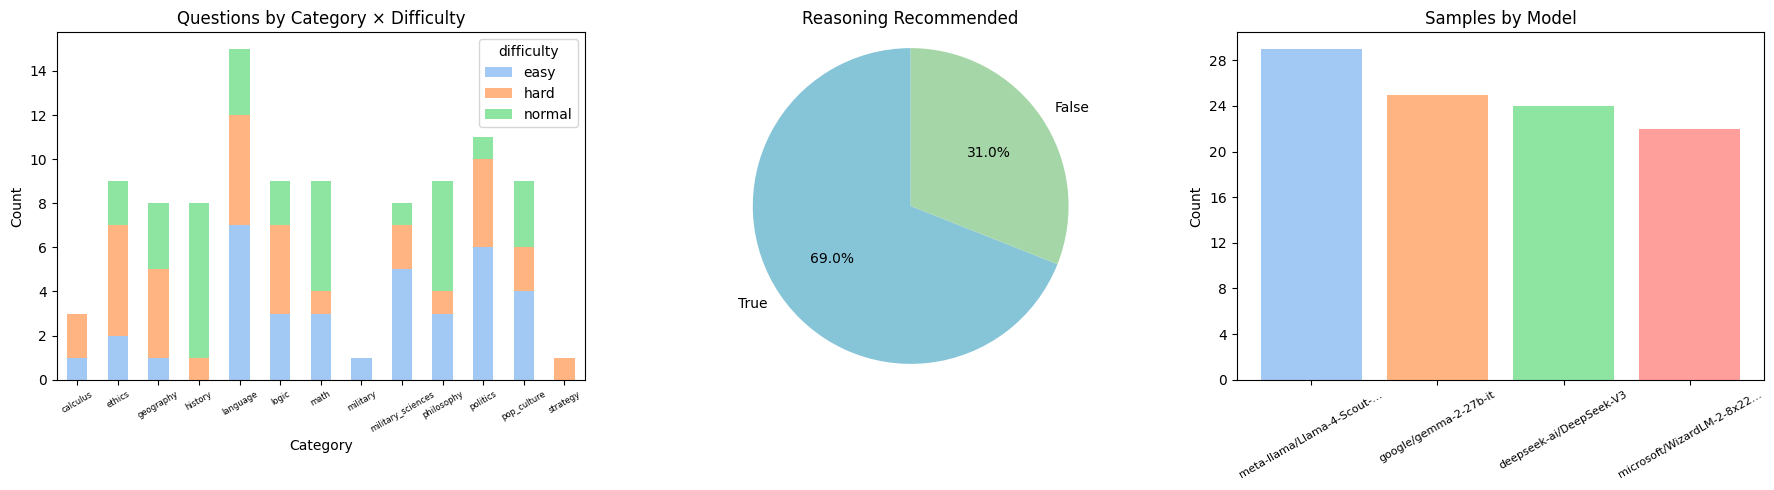

In [9]:
# set color theme
plt.style.use("seaborn-v0_8-pastel")

# dashboarding format
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# count of category stacked by difficulty
pivot = df.pivot_table(index="category", columns="difficulty", aggfunc="size", fill_value=0)
pivot.plot(
    kind="bar",
    stacked=True,
    ax=axes[0],
    color=sns.color_palette("pastel", n_colors=len(pivot.columns))
)
axes[0].set_title("Questions by Category × Difficulty")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', labelrotation=30, labelsize=6)
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # ✅ Only integer ticks

# proportion of use_reasoning values
reasoning_colors = {
    True: "#86c5d8",   # pastel blue
    False: "#a5d6a7"   # pastel green
}
reasoning_counts = df["use_reasoning"].value_counts()
axes[1].pie(
    reasoning_counts,
    labels=["True", "False"],
    autopct='%1.1f%%',
    colors=[reasoning_colors.get(k) for k in reasoning_counts.index],
    startangle=90
)
axes[1].set_title("Reasoning Recommended")
axes[1].axis('equal')

# model usage bar chart
model_counts = df["model"].value_counts()
truncated_labels = [m[:25] + "…" if len(m) > 25 else m for m in model_counts.index]
bar_colors = sns.color_palette("pastel", n_colors=len(model_counts))

axes[2].bar(truncated_labels, model_counts.values, color=bar_colors)
axes[2].set_title("Samples by Model")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis='x', labelrotation=30, labelsize=8)
axes[2].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# display charts
plt.tight_layout()
plt.show()


## Setup for Reasoning

This section of the notebook setups up the [Reasoning Generation Loop](#reasoning-generation-loop). These variables are visualized in [Reasoning Dataset Analytics](#reasoning-dataset-analytics) to give you an understanding of how well your configuation is working. More information about interpreting those graphs can be found in that section.

In [10]:
# setup tokenizer for token counting
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# initialize memory dictionaries
reasoning_strings = []
token_lengths = []
token_limit_hits = []
response_times = []
request_timestamps = deque()

# time and error counting
error_count = 0
start_time = time.time()

# extract configuration variables
max_tokens = config["max_tokens"]
max_qpm = config["max_queries_per_minute"]
window_seconds = config["rate_limit_window_seconds"]
reasoning_model = config["reasoning_model"]

print(f"\n🤔 Reasoning Generation is configured to use: {reasoning_model}...\n")


🤔 Reasoning Generation is configured to use: deepseek-ai/DeepSeek-R1...



## Reasoning Generation Loop

This loop iterates through each line of the output dataframe from [Question Generation Loop](#question-generation-loop) and polls [DeepSeek-R1](https://huggingface.co/deepseek-ai/DeepSeek-R1) to generate a `<think>` block (representing the reasoning-only segment of an answer) with fewer than the defined amount of tokens. The `max_tokens` parameter is configurable and injected into the query sent to the model itself to ensure that the the limit is communicated literally as well as programatically, this has been observed to generate fewer incomplete or cut-off responses.

> Please note, regardless of prompting, `max_tokens` configurations of less than 256 tokens appear to overflow and be cut off nearly 100% of the time.

In [ ]:
# reasoning generation loop
for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reasoning via {reasoning_model}"):
    question = row["question"]
    label = row["use_reasoning"]
    category = row["category"]
    label_str = "does" if label else "does not"

    # define prompt
    # during generation it was observed that r1 often had a hard time responding to the target question rather than just trying to answer the {question}
    # this is why there is redundant prompting emphasizing the goal of the reasoning task
    prompt = f"""
<think>
You are a minimal reasoning agent tasked with quickly evaluating why a question requires multi-step logical reasoning or not. Do not attempt to answer the question, but simply explain why the question does or does not require reasoning.

The following question {label_str} require reasoning.

Question: {question}

Please do not think for more than {max_tokens} tokens.

Remember, your task is not to answer the question, but simply explain why the question requires reasoning or not.
</think>
""".strip()

    # rate limiting controls
    now = time.time()
    request_timestamps.append(now)
    while len(request_timestamps) > max_qpm:
        if now - request_timestamps[0] < window_seconds:
            sleep_time = window_seconds - (now - request_timestamps[0])
            print(f"⏳ Rate limit hit — sleeping {sleep_time:.1f}s...")
            time.sleep(sleep_time)
        else:
            request_timestamps.popleft()

    try:
        req_start = time.time()
        response = client.chat.completions.create(
            model=reasoning_model,
            messages=[{"role": "user", "content": prompt}],
            stop=["</think>"],
            max_tokens=max_tokens
        )
        req_end = time.time()
        response_times.append(req_end - req_start)

        response_text = response.choices[0].message.content.strip()
        full_reasoning = response_text.replace("\n", " ").replace("\r", " ").strip() + " </think>"
        reasoning_strings.append(full_reasoning)

        token_count = len(tokenizer.encode(response_text))
        token_lengths.append(token_count)
        token_limit_hits.append(token_count >= max_tokens)

    except Exception as e:
        error_count += 1
        print(f"⚠️ Error on question: {question[:60]}... → {e}")
        print("⏱️ Retrying after 60 seconds...")
        time.sleep(60)

        try:
            retry_start = time.time()
            response = client.chat.completions.create(
                model=reasoning_model,
                messages=[{"role": "user", "content": prompt}],
                stop=["</think>"],
                max_tokens=max_tokens
            )
            retry_end = time.time()
            response_times.append(retry_end - retry_start)

            response_text = response.choices[0].message.content.strip()
            full_reasoning = response_text.replace("\n", " ").replace("\r", " ").strip() + " </think>"
            reasoning_strings.append(full_reasoning)

            token_count = len(tokenizer.encode(response_text))
            token_lengths.append(token_count)
            token_limit_hits.append(token_count >= max_tokens)

        except Exception as e2:
            error_count += 1
            print(f"❌ Retry failed → {e2}")
            reasoning_strings.append("<think>Error generating reasoning</think>")
            token_lengths.append(0)
            token_limit_hits.append(False)
            response_times.append(0.0)

# build output dataframe
df["reasoning"] = reasoning_strings
end_time = time.time()


## Update Output

The `reasoning` column is added to the in-memory DataFrame during the [Reasoning Generation Loop](#reasoning-generation-loop). If you have configured `'save_to_csv':True` in the [Configuration](#configuration), the following cell appends a formated, single-line `reasoning` column to your local CSV.

In [12]:
# check save_to_csv parameter from configuration and update local csv accordingly
# please note, the process will error if you've deleted the underlying csv between its creation and this step
if config.get("save_to_csv", False):
    csv_path = config["csv_filename"]

    if os.path.exists(csv_path):
        try:
            df.to_csv(csv_path, index=False, quoting=csv.QUOTE_ALL)
            print(f"\n✅ Reasoning column appended and saved to existing CSV: {csv_path}")
        except Exception as e:
            print(f"❌ Error saving to CSV: {e}")
    else:
        print(f"\n⚠️ CSV file not found: {csv_path}. No file saved, but reasoning is attached to DataFrame.")
else:
    print("📁 save_to_csv is False — skipping file write, reasoning is only in-memory.")



✅ Reasoning column appended and saved to existing CSV: tron_demo.csv


## Reasoning Dataset Analytics

The charts in this dashboard report some basic analytics about the Reasoning Generation Loop. You can use these charts to quickly analyze your [Configuration](#configuration) and [Setup](#setup-for-reasoning) parrameters.

For example, if you see a large proportion of prompts reaching your configured `max_tokens`, it might make sense to increase that limit to ensure that the majority of prompts capture the full `reasoning` output.

You will also see the overall distribution of tokens across all prompts as well as a number of other KPIs from the generation task. 

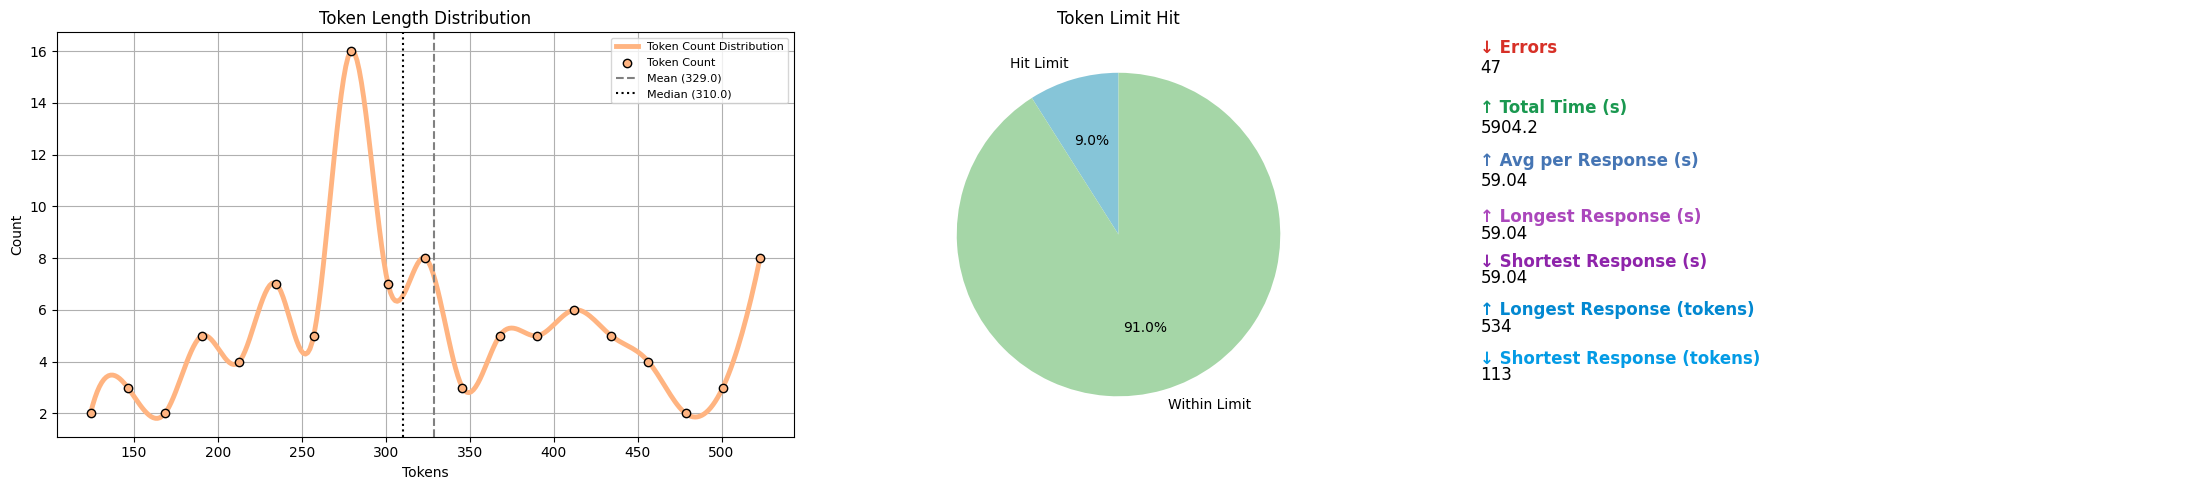

In [21]:
# set color theme
plt.style.use("seaborn-v0_8-pastel")

# build token_lengths distribution histogram
bins = np.linspace(min(token_lengths), max(token_lengths), 20)
counts, edges = np.histogram(token_lengths, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

# ignore 0 bins
centers_nonzero = centers[counts > 0]
counts_nonzero = counts[counts > 0]

# count bins
total_time = end_time - start_time
time_per_response = total_time / len(df)
mean_tokens = np.mean(token_lengths)
median_tokens = np.median(token_lengths)

# generation kpis
max_tokens_used = np.max(token_lengths)
min_tokens_used = np.min(token_lengths)
response_times = [time_per_response for _ in token_lengths]
max_time = np.max(response_times)
min_time = np.min(response_times)

# set dashboard layout
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

# token length distribution (line chart)
if len(centers_nonzero) >= 4:
    x_smooth = np.linspace(centers_nonzero.min(), centers_nonzero.max(), 300)
    spline = make_interp_spline(centers_nonzero, counts_nonzero, k=3)
    y_smooth = spline(x_smooth)

    axes[0].plot(x_smooth, y_smooth, color="#ffb481", linewidth=3.5, label="Token Count Distribution")
    axes[0].scatter(centers_nonzero, counts_nonzero, color="#ffb481", edgecolor="black", zorder=3, label="Token Count")
else:
    axes[0].plot(centers_nonzero, counts_nonzero, color="#ffb481", linewidth=3.5, label="Token Lengths")
    axes[0].scatter(centers_nonzero, counts_nonzero, color="#ffb481", edgecolor="black", zorder=3)

axes[0].axvline(mean_tokens, color="gray", linestyle="--", linewidth=1.5, label=f"Mean ({mean_tokens:.1f})")
axes[0].axvline(median_tokens, color="black", linestyle=":", linewidth=1.5, label=f"Median ({median_tokens:.1f})")

axes[0].set_title("Token Length Distribution")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Count")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].legend(fontsize=8)
axes[0].grid(True)

# token limit (pie chart))
limit_hit_counts = {
    "Hit Limit": sum(token_limit_hits),
    "Within Limit": len(token_limit_hits) - sum(token_limit_hits)
}
axes[1].pie(
    limit_hit_counts.values(),
    labels=limit_hit_counts.keys(),
    autopct='%1.1f%%',
    colors=["#86c5d8", "#a5d6a7"],
    startangle=90
)
axes[1].set_title("Token Limit Hit")

# kpis (kpis)
axes[2].axis("off")
kpi_x = 0.05

# number of errors
axes[2].text(kpi_x, 0.95, "↓ Errors", fontsize=12, fontweight="bold", color="#d73027")
axes[2].text(kpi_x, 0.90, f"{error_count}", fontsize=12)

# total execution time
axes[2].text(kpi_x, 0.80, "↑ Total Time (s)", fontsize=12, fontweight="bold", color="#1a9850")
axes[2].text(kpi_x, 0.75, f"{total_time:.1f}", fontsize=12)

# avg response time
axes[2].text(kpi_x, 0.67, "↑ Avg per Response (s)", fontsize=12, fontweight="bold", color="#4575b4")
axes[2].text(kpi_x, 0.62, f"{time_per_response:.2f}", fontsize=12)

# longest response time
axes[2].text(kpi_x, 0.53, "↑ Longest Response (s)", fontsize=12, fontweight="bold", color="#ab47bc")
axes[2].text(kpi_x, 0.49, f"{max_time:.2f}", fontsize=12)

# shortest response time
axes[2].text(kpi_x, 0.42, "↓ Shortest Response (s)", fontsize=12, fontweight="bold", color="#8e24aa")
axes[2].text(kpi_x, 0.38, f"{min_time:.2f}", fontsize=12)

# longest response tokens
axes[2].text(kpi_x, 0.30, "↑ Longest Response (tokens)", fontsize=12, fontweight="bold", color="#0288d1")
axes[2].text(kpi_x, 0.26, f"{max_tokens_used}", fontsize=12)

# shortest response tokens
axes[2].text(kpi_x, 0.18, "↓ Shortest Response (tokens)", fontsize=12, fontweight="bold", color="#039be5")
axes[2].text(kpi_x, 0.14, f"{min_tokens_used}", fontsize=12)

# display
plt.tight_layout()
plt.show()

## Upload to Hugging Face Hub

Now that you've generated your own dataset using the TRON pipeline, upload it the Hugging Face Hub so that others can use it to create powerful meta-reasoning models.

In [22]:
# create remote repo
api = HfApi()
api.create_repo(repo_id="ZennyKenny/TRON-dataset-v.1.0", repo_type="dataset", exist_ok=True)

# upload to remote
hf_dataset = Dataset.from_pandas(df)
hf_dataset.push_to_hub("ZennyKenny/TRON-dataset-v.1.0")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ZennyKenny/TRON-dataset-v.1.0/commit/7a192f8ea53cd5b944744badd0be3c496bb859d7', commit_message='Upload dataset', commit_description='', oid='7a192f8ea53cd5b944744badd0be3c496bb859d7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ZennyKenny/TRON-dataset-v.1.0', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ZennyKenny/TRON-dataset-v.1.0'), pr_revision=None, pr_num=None)

### Update Existing Dataset

Time, use case, and compute restrictions sometimes mean that it might make sense to upload your dataset in chunks or discrete generation actions, tweaking your configuration or amount of generated data as you go.

Use the cell below if you'd like to append your newly generated dataset to one that you have already created.

> Please execute this cell with caution as you will overwrite your remote repo.

In [ ]:
# load remote repo into memory as dataframe
remote_dataset = load_dataset("ZennyKenny/TRON-dataset-v.1.0", split="train")
remote_df = remote_dataset.to_pandas()

# create new dataframe by appending dataframe made with notebook to dataframe made from remote repo
combined_df = pd.concat([remote_df, df], ignore_index=True)

# push dataframe back to huggingface hub
api = HfApi()
api.create_repo(repo_id="ZennyKenny/TRON-dataset-v.1.0", repo_type="dataset", exist_ok=True)
Dataset.from_pandas(combined_df).push_to_hub("ZennyKenny/TRON-dataset-v.1.0")